# Youtube views prediction
* Context: Want to predict youtube video views based on some variables using linear regression

### Importing library and dataset

In [1]:
# Standard python libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Preprocessing libraries
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.compose import TransformedTargetRegressor

# Modelling libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor 
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Evaluation libraries
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# Importing dataset from local storage
df = pd.read_excel('youtube_statistics.xlsx')

# EDA

In [3]:
# Quick look at the data
df.head(3)

,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,description,No_tags,desc_len,len_title,publish_date
0,2017-11-14,Sharry Mann: Cute Munda ( Song Teaser) | Parmi...,Lokdhun Punjabi,1,12:20:39,"sharry mann|""sharry mann new song""|""sharry man...",1096327,33966,798,882,False,False,False,Presenting Sharry Mann latest Punjabi Song Cu...,15,920,81,2017-11-12
1,2017-11-14,"पीरियड्स के समय, पेट पर पति करता ऐसा, देखकर दं...",HJ NEWS,25,05:43:56,"पीरियड्स के समय|""पेट पर पति करता ऐसा""|""देखकर द...",590101,735,904,0,True,False,False,"पीरियड्स के समय, पेट पर पति करता ऐसा, देखकर दं...",19,2232,58,2017-11-13
2,2017-11-14,Stylish Star Allu Arjun @ ChaySam Wedding Rece...,TFPC,24,15:48:08,Stylish Star Allu Arjun @ ChaySam Wedding Rece...,473988,2011,243,149,False,False,False,Watch Stylish Star Allu Arjun @ ChaySam Weddin...,14,482,58,2017-11-12


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36791 entries, 0 to 36790
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trending_date           36791 non-null  object        
 1   title                   36791 non-null  object        
 2   channel_title           36791 non-null  object        
 3   category_id             36791 non-null  int64         
 4   publish_time            36791 non-null  object        
 5   tags                    36791 non-null  object        
 6   views                   36791 non-null  int64         
 7   likes                   36791 non-null  int64         
 8   dislikes                36791 non-null  int64         
 9   comment_count           36791 non-null  int64         
 10  comments_disabled       36791 non-null  bool          
 11  ratings_disabled        36791 non-null  bool          
 12  video_error_or_removed  36791 non-null  bool  

The missing values is only in 'description' column, which normally it's normal for youtube videos to not including video description. And since this is a regression model, some of the string type columns such as description will be dropped.

<AxesSubplot:>

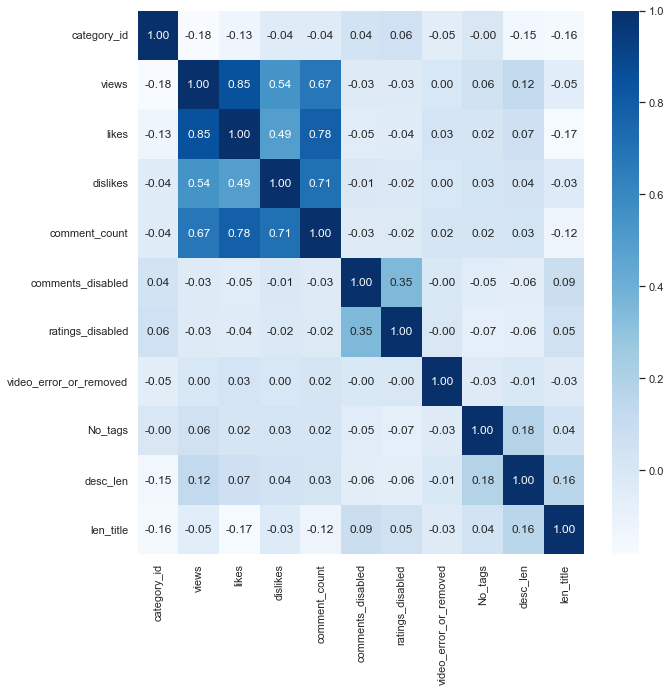

In [5]:
sns.set(rc={'figure.figsize':(10,10)})
sns.heatmap(df.corr(), cmap='Blues', annot=True, fmt='.2f')

This is actually a good dataset, with 'views' as the target it has very strong correlation with 'likes' variable. Instictively with a 85% correlation between target and a variable, by just using 'likes' variable it should be sufficient to accurately predict the regression model.

Looking at other variable 'comment_count' is redundant with the most important variable 'views', so it can be considered to not use 'comment_count' variable.

# Preprocessing

In [6]:
# Checking duplicates
print(df.duplicated().sum())

4229


There are 4229 duplicated values, so lets drop it

In [7]:
# Dropping duplicates
df = df.drop_duplicates()
print('*'*50, '\n')

************************************************** 



Since datetime type variable can't directly used in regression model, so some variables need to be preprocessed where there are 2 preprocessing here:
* Combine 'trending_date' and 'publish_date' by substracting the values to see how many days it took to be a trending video.
* Converting 'publish_time' into six category of time in a day

In [8]:
# To see how many days it took to be trending since published
df['trending_gap'] = pd.to_datetime(df['trending_date']) - df['publish_date']
# Took the number only
df['trending_gap'] = df['trending_gap'].dt.days
print('*'*50)

**************************************************


In [9]:
# Converting publish time into 6 category
def daypart(hour):
    if hour in [2,3,4,5]:
        return 'dawn'
    elif hour in [6,7,8,9]:
        return 'morning'
    elif hour in [10,11,12,13]:
        return 'noon'
    elif hour in [14,15,16,17]:
        return 'afternoon'
    elif hour in [18,19,20,21]:
        return 'evening'
    elif hour in [22,23,0,1]:
        return 'midnight'

df['publish_time'] = pd.to_datetime(df['publish_time'])
df['publish_time'] = df['publish_time'].dt.hour.apply(daypart)

# Feature Engineering

String(object) type variables will be hard to be processed in a regression model and datetime type variable also already been preprocessed so it can be dropped

In [10]:
# Unrelevant Features
drop_dtypes = ['object','datetime64[ns]']
drops = list(df.select_dtypes(include=drop_dtypes).columns)
drops.remove('publish_time')
df = df.drop([*drops], axis=1)

Separating numerical and categorical variables

In [11]:
cat_dtypes = ['object','bool']
cats = list(df.select_dtypes(include=cat_dtypes).columns)
# cats.append('category_id')

nums = list(df.select_dtypes(exclude=cat_dtypes).columns)
nums.remove('category_id')

Checking numerical values distribution

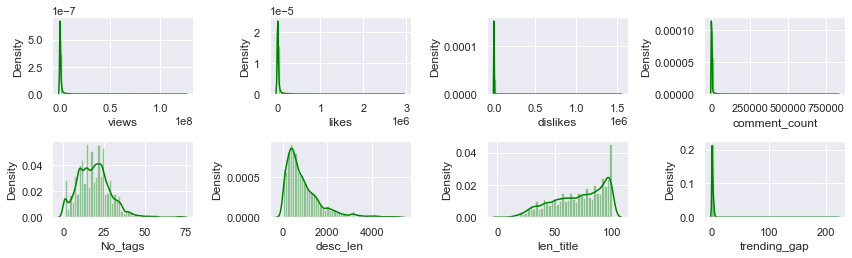

In [12]:
plt.figure(figsize=(12, 5))
for i in range(0, len(nums)):
    plt.subplot(3, len(nums)/2, i+1)
    sns.distplot(df[nums[i]], color='green')
    plt.tight_layout()

Since there are many outliers normally it should be dropped, but let's see first if keeping those outliers can improve model accuracy

And removing outliers also removing 8000 rows of data, so let's try keeping a separate dataset witout outliers

In [13]:
print(f'rows before outlier filter : {len(df)}')
filtered_entries = np.array([True] * len(df))

for column in [*nums]:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    low_limit = Q1 - (IQR * 1.5)
    high_limit = Q3 + (IQR * 1.5)
  
    filtered_entries = (df[column]>=low_limit) & (df[column]<=high_limit) & filtered_entries
    
dfo = df[filtered_entries]
print(f'rows after outlier filter : {len(dfo)}')

rows before outlier filter : 32562
rows after outlier filter : 24410


Normally numerical values needs to be scaled, but let's see first if keeping original values can improve model accuracy

In [14]:
# for num in nums:
#     df[num] = MinMaxScaler().fit_transform(df[num].values.reshape(len(df),1))

# df[nums] = StandardScaler().fit_transform(df[nums])

Checking categorical variable values

In [15]:
for cat in df[cats]:
    print(f'{cat :-<25}{df[cat].unique()}')

publish_time-------------['noon' 'dawn' 'afternoon' 'morning' 'midnight' 'evening']
comments_disabled--------[False  True]
ratings_disabled---------[False  True]
video_error_or_removed---[False  True]


One hot encoding for categorical variables

In [16]:
df=pd.get_dummies(df, columns=['publish_time'])

# Modelling

In [17]:
# Make the model by choosing the variables want to be dropped
drop_cols = ['views', 'category_id']
X = df.loc[:, ~df.columns.isin(drop_cols)]

# Make the model by choosing the variables want to be used
# used_cols = ['likes', 'dislikes', 'comment_count', 'comments_disabled',
#              'ratings_disabled', 'video_error_or_removed', 'No_tags', 'desc_len',
#              'len_title', 'trending_gap']
# used_cols = ['likes', 'dislikes', 'comment_count', 
#              'No_tags', 'desc_len', 'trending_gap']
# X = df.loc[:, df.columns.isin(used_cols)]
y = df['views']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
def eval_regression(model, pred, xtrain, ytrain, xtest, ytest):
    print("MAE : %.3f" % mean_absolute_error(ytest, pred))
    print("RMSE : %.3f" % mean_squared_error(ytest, pred, squared=False))
    print('R2 score : %.3f' % r2_score(ytest, pred))

In [19]:
def boost_models(x):
    regr_trans = TransformedTargetRegressor(
        regressor=x, transformer=QuantileTransformer(output_distribution='normal'))
    regr_trans.fit(Xtrain, ytrain)
    ypred = regr_trans.predict(Xtest)
    algoname = x.__class__.__name__
    score = algoname, r2_score(ytest, ypred), mean_absolute_error(ytest, ypred), np.sqrt(mean_squared_error(ytest, ypred))
    return score

In [20]:
algo = [DecisionTreeRegressor(), RandomForestRegressor(), XGBRegressor(),
        GradientBoostingRegressor(), LGBMRegressor()]
score = []

for alg in algo:
    score.append(boost_models(alg))
    
score_df = pd.DataFrame(score, columns=['Model', 'R2_Score', 'MAE', 'RMSE'])
score_df.sort_values('R2_Score')

,Model,R2_Score,MAE,RMSE
3,GradientBoostingRegressor,0.819300,398440.353193,1.381070e+06
4,LGBMRegressor,0.842617,345752.368612,1.288889e+06
0,DecisionTreeRegressor,0.923297,313547.372170,8.997902e+05
2,XGBRegressor,0.941949,281386.079465,7.827805e+05
1,RandomForestRegressor,0.952696,247549.432055,7.066213e+05


### Comparing if using QuantileTransformer is actually giving better results

In [21]:
rf = RandomForestRegressor()
rf.fit(Xtrain, ytrain)
ypred = rf.predict(Xtest)
eval_regression(rf, ypred, Xtrain, ytrain, Xtest, ytest)

MAE : 250837.297
RMSE : 655845.184
R2 score : 0.959


In [22]:
rf = RandomForestRegressor()
ttr = TransformedTargetRegressor(
    regressor=rf, transformer=QuantileTransformer(output_distribution='normal'))
ttr.fit(Xtrain, ytrain)
ypred = ttr.predict(Xtest)
eval_regression(ttr, ypred, Xtrain, ytrain, Xtest, ytest)

MAE : 247193.568
RMSE : 706256.132
R2 score : 0.953


### Checking if removing outliers gave better results

In [23]:
dfo=pd.get_dummies(dfo, columns=['publish_time'])
X = dfo.loc[:, ~dfo.columns.isin(drop_cols)]
y = dfo['views']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

score = []
for alg in algo:
    score.append(boost_models(alg))
    
score_df = pd.DataFrame(score, columns=['Model', 'R2_Score', 'MAE', 'RMSE'])
score_df.sort_values('R2_Score')

,Model,R2_Score,MAE,RMSE
0,DecisionTreeRegressor,0.417023,136705.197800,236301.909650
3,GradientBoostingRegressor,0.631993,115254.874570,187745.393586
4,LGBMRegressor,0.706760,100975.382226,167591.863864
1,RandomForestRegressor,0.719359,97110.572505,163952.122009
2,XGBRegressor,0.738428,93897.775611,158283.983282


### This GridSearchCV uses a lot of computing, only use this if have many free time

In [24]:
# param_grid = {'n_estimators': [2500],  
#               'max_depth': [8],
#               'reg_lambda' :[0.25]
#              }
                
# grid = GridSearchCV(XGBRegressor(), param_grid, refit = True, verbose = 3, n_jobs=-1)
# regr_trans = TransformedTargetRegressor(regressor=grid, transformer=QuantileTransformer(output_distribution='normal'))

# # fitting the model for grid search 
# grid_result=regr_trans.fit(Xtrain, ytrain)
# best_params=grid_result.regressor_.best_params_
# print(best_params)

# #using best params to create and fit model
# best_model = XGBRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], reg_lambda=best_params["reg_lambda"])
# regr_trans = TransformedTargetRegressor(regressor=best_model, transformer=QuantileTransformer(output_distribution='normal'))
# regr_trans.fit(Xtrain, ytrain)
# ypred = regr_trans.predict(Xtest)

# #evaluate metrics
# eval_regression(regr_trans, ypred, Xtrain, ytrain, Xtest, ytest)

### Conclusion

* Dropping outliers actually give a better MAE & RMSE score (smaller number is better), but have a huge drop on R2 score (higher number is better)

* It's better to keep the outliers as it give more accurate R2 score and can also predict more popular videos (videos with huge likes etc)

### What to improve

* Around 95% R2 score is actualy good, but with the MAE & RMSE is still too huge, can't actually declare this is a good model yet.
* Deeper exploration and analysis on features should be conducted to give better insight how to improve the model
* Try deeper learning using RandomizedSearchCV or GridSearchCV should give better results, but it will took more time to tune the hyperparameters and run the test

### Reference article:
* Improving regression model:
https://towardsdatascience.com/how-to-improve-the-accuracy-of-a-regression-model-3517accf8604
* DateTime engineering: https://towardsdatascience.com/feature-engineering-on-date-time-data-90f6e954e6b8